In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import pandas as pd
import cv2
import os
# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display



2024-02-19 21:43:51.876185: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 21:43:51.876408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 21:43:52.065242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [4]:

# Path to the folder containing images
folder_path = '/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images'

# List all files in the folder
image_files = os.listdir(folder_path)

# Iterate over each image file
for file_name in image_files[:10]:
    # Construct the full path to the image file
    image_path = os.path.join(folder_path, file_name) 
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    
    # Process the image as needed
    # (e.g., perform further operations, analysis, etc.)
    
    # Example: Print image shape



In [5]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [8]:
keypoints_with_scores=[]
# Iterate over each image file
for file_name in image_files[:10]:
    # Construct the full path to the image file
    image_path = os.path.join(folder_path, file_name)
    
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_score = movenet(input_image)
    keypoints_with_scores.append(keypoints_with_score)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(np.squeeze(display_image.numpy(), axis=0), keypoints_with_score)

    

In [9]:
keypoints_with_scores = np.array(keypoints_with_scores)


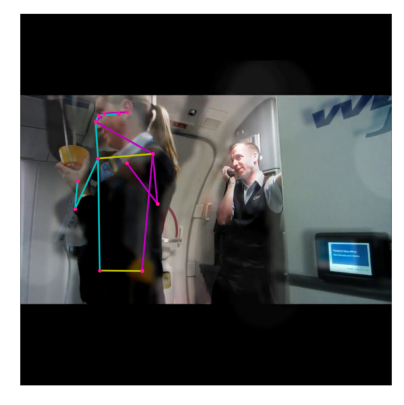

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')
plt.show()  # Show the visualization for each image


In [10]:

def calculate_distance(keypoint1, keypoint2):
    """Calculate the Euclidean distance between two keypoints."""
    return np.linalg.norm(keypoint1 - keypoint2)

def calculate_ratio(distance1, distance2):
    """Calculate the ratio between two distances."""
    return distance1 / distance2

def calculate_angle(keypoint1, keypoint2, keypoint3):
    """Calculate the angle between three keypoints."""
    vector1 = keypoint1 - keypoint2
    vector2 = keypoint3 - keypoint2
    cosine_angle = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    angle_radians = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle_radians)



In [12]:
shoulder_widths=[]
hip_widths=[]
waist_sizes=[]
bust_sizes=[]
hip_sizes=[]
waist_to_hip_ratios=[]
bust_to_waist_ratios=[]
angle_left_arm_torsos=[]

def estimate_physical_attributes(keypoints_with_scores):
    """Estimate physical attributes using keypoints with scores."""
    # Assuming the order of keypoints: [nose, left_eye, right_eye, left_ear, right_ear, 
    #                                    left_shoulder, right_shoulder, left_elbow, right_elbow, 
    #                                    left_wrist, right_wrist, left_hip, right_hip, 
    #                                    left_knee, right_knee, left_ankle, right_ankle]
    
    # Extract keypoints from the array
    for keypoints in keypoints_with_scores:  # Assuming there's only one batch
       # print('I am donoing keypoints ',keypoints)
        # Assuming the order of keypoints in the array matches the order above
        left_shoulder = keypoints[0][0][5]
        right_shoulder = keypoints[0][0][6]
        left_hip = keypoints[0][0][11]
        right_hip = keypoints[0][0][12]
        
        # Calculate distances between keypoints
        shoulder_width = right_shoulder[0] - left_shoulder[0]
        shoulder_widths.append(shoulder_width)
        hip_width = right_hip[0] - left_hip[0]
        hip_widths.append(shoulder_width)
        waist_width = 0.8 * hip_width  # Assuming waist is 75% of hip width
        bust_width = 0.95 * hip_width  # Assuming bust is 95% of hip width
        #bust_sizes.append(bust_width)
        #print(waist_width)
        # Calculate ratios
        waist_to_hip_ratio = waist_width / hip_width
        waist_to_hip_ratios.append(waist_to_hip_ratio)
       # print(bust_width)
        bust_to_waist_ratio = bust_width / waist_width
        #print(bust_to_waist_ratio)
        bust_to_waist_ratios.append(bust_to_waist_ratio)

        # Calculate angle between left arm and torso
        angle_left_arm_torso = calculate_angle(left_shoulder, keypoints[0][0][7], left_hip)
        angle_left_arm_torsos.append(angle_left_arm_torso)
        # Estimate physical attributes
        waist_size = waist_width  # Using the estimated waist width as the waist size
        waist_sizes.append(waist_size)
        bust_size = bust_width  # Using the estimated bust width as the bust size
        bust_sizes.append(bust_size)
        hip_size = hip_width  # Using the calculated hip width as the hip size
        hip_sizes.append(hip_size)

    return shoulder_widths, hip_widths, waist_sizes, bust_sizes, hip_sizes, waist_to_hip_ratios, bust_to_waist_ratios, angle_left_arm_torsos

# Sample keypoints with scores
#keypoints_with_scores = keypoints_with_scores
# Estimate physical attributes
#shoulder_width, hip_width, waist_size, bust_size, hip_size, waist_to_hip_ratio, bust_to_waist_ratio, angle_left_arm_torso = estimate_physical_attributes(keypoints_with_scores)

'''print("Shoulder Widths:", shoulder_width)
print("Hip Widths:", hip_width)
print("Waist Sizes:", waist_size)
print("Bust Sizes:", bust_size)
print("Hip Sizes:", hip_size)
print("Waist-to-Hip Ratios:", waist_to_hip_ratio)
print("Bust-to-Waist Ratios:", bust_to_waist_ratio)
print("Angle between Left Arm and Torsos:", angle_left_arm_torso)
'''

'print("Shoulder Widths:", shoulder_width)\nprint("Hip Widths:", hip_width)\nprint("Waist Sizes:", waist_size)\nprint("Bust Sizes:", bust_size)\nprint("Hip Sizes:", hip_size)\nprint("Waist-to-Hip Ratios:", waist_to_hip_ratio)\nprint("Bust-to-Waist Ratios:", bust_to_waist_ratio)\nprint("Angle between Left Arm and Torsos:", angle_left_arm_torso)\n'

**c09dd740b164b38968ba34d2ae7ce3f7f121c47957432657072c94d2**

In [13]:
facial_symmetry_scores=[]
forehead_sizes=[]
def calculate_symmetry_score(left_keypoints, right_keypoints):
    """Calculate facial symmetry score based on the distances between corresponding left and right keypoints."""
    symmetry_scores = []
    for left, right in zip(left_keypoints, right_keypoints):
        distance_left = calculate_distance(left, right)
        symmetry_scores.append(distance_left)
    return np.mean(symmetry_scores)

def estimate_forehead_size(eye_keypoints):
    """Estimate forehead size based on the vertical distance between the eyes."""
    eye_distance = calculate_distance(eye_keypoints[0], eye_keypoints[1])
    return eye_distance * 0.5  # Assuming the forehead size is half the distance between the eyes

# Sample keypoints for facial features (replace with actual keypoints from your model)
for keys in keypoints_with_scores:
    left_eye_keypoint = keys[0][0][1]  # Left eye keypoints
    
    right_eye_keypoint = keys[0][0][2]  # Right eye keypoints
    forehead_size = estimate_forehead_size([left_eye_keypoint, right_eye_keypoint])
    facial_symmetry_score = calculate_symmetry_score(left_eye_keypoint, right_eye_keypoint)
    forehead_sizes.append(forehead_size)
    facial_symmetry_scores.append(facial_symmetry_score)

# Calculate facial symmetry score


# Estimate forehead size


'''print("Facial Symmetry Score:", facial_symmetry_scores)
print("Estimated Forehead Size:", forehead_sizes)
'''

NameError: name 'keypoints_with_scores' is not defined

In [13]:
!pip install textrazor
import textrazor

In [16]:
import textrazor

def generate_textual_descriptions(input_data):
    # Initialize TextRazor API
    textrazor.api_key = "c09dd740b164b38968ba34d2ae7ce3f7f121c47957432657072c94d2"
    client = textrazor.TextRazor(extractors=["entities", "topics"])

    # Mapping of relevant entities to their corresponding features
    relevant_entities = {
        "Hip": "Hip",
        "Waist": "Waist",
        "Shoulder": "Shoulder",
        "Facial symmetry": "Facial Symmetry",
        "Estimated Forehead Size": "Estimated Forehead Size"
    }
    generated_texts = []

    # Generate textual descriptions for each feature
    for feature, values in input_data.items():
        # Initialize textual description for the feature
        generated_text = f"The {feature} sizes are:\n"

        # Iterate over each value for the feature
        for i, value in enumerate(values):
            # Add value description to the generated text
            generated_text += f"- Individual {i+1}: {value}\n"

            # Analyze value description using TextRazor
            response = client.analyze(str(value))

            # Generate textual description for the value
            for entity in response.entities():
                if entity.id in relevant_entities:
                    generated_text += f"    The {relevant_entities[entity.id]} size for individual {i+1} is {entity.relevance_score}.\n"

        generated_texts.append(generated_text)

        # Print generated textual description for the feature
        print(f"Generated Textual Description for {feature}:")
        print(generated_text)

    return generated_texts

# Example input data (replace with your actual data)
input_data = {
    "Shoulder Widths": shoulder_width,
    "Hip Widths": hip_width,
    "Waist Sizes": waist_size,
    "Bust Sizes": bust_size,
    "Hip Sizes": hip_size,
    "Waist-to-Hip Ratios": waist_to_hip_ratio,
    "Bust-to-Waist Ratios": bust_to_waist_ratio,
    "Angle between Left Arm and Torsos": angle_left_arm_torso,
    "Facial Symmetry Score": facial_symmetry_scores,
    "Estimated Forehead Size": forehead_sizes
}

# Generate textual descriptions using the function
generated_texts = generate_textual_descriptions(input_data)


Generated Textual Description for Shoulder Widths:
The Shoulder Widths sizes are:
- Individual 1: 0.011850327253341675
- Individual 2: 0.006000518798828125
- Individual 3: 0.00845634937286377
- Individual 4: 0.004043310880661011
- Individual 5: -0.024017155170440674
- Individual 6: 0.0024461448192596436
- Individual 7: 0.010867297649383545
- Individual 8: -0.021112799644470215
- Individual 9: -0.0012947320938110352
- Individual 10: 0.012406796216964722

Generated Textual Description for Hip Widths:
The Hip Widths sizes are:
- Individual 1: 0.011850327253341675
- Individual 2: 0.006000518798828125
- Individual 3: 0.00845634937286377
- Individual 4: 0.004043310880661011
- Individual 5: -0.024017155170440674
- Individual 6: 0.0024461448192596436
- Individual 7: 0.010867297649383545
- Individual 8: -0.021112799644470215
- Individual 9: -0.0012947320938110352
- Individual 10: 0.012406796216964722

Generated Textual Description for Waist Sizes:
The Waist Sizes sizes are:
- Individual 1: 0.01

In [17]:
import gensim.downloader as api

# Load pre-trained Word2Vec model
w2v_model = api.load("word2vec-google-news-300")

[=====---------------------------------------------] 10.3% 171.7/1662.8MB downloaded

In [18]:
def convert_to_text_vectors(generated_texts, w2v_model):
    # Convert generated text lines to numerical vectors
    text_vectors = []
    for line in generated_texts:
        tokens = line.lower().split()  # Tokenize line and convert to lowercase
        # Convert tokens to numerical vectors using Word2Vec model
        vectors = [w2v_model.get_vector(word) for word in tokens if word in w2v_model.key_to_index]
        text_vectors.append(vectors)
    
    return text_vectors

# Example usage:
text_vectors = convert_to_text_vectors(generated_texts, w2v_model)
text_vectors

[[array([ 0.08007812,  0.10498047,  0.04980469,  0.0534668 , -0.06738281,
         -0.12060547,  0.03515625, -0.11865234,  0.04394531,  0.03015137,
         -0.05688477, -0.07617188,  0.01287842,  0.04980469, -0.08496094,
         -0.06347656,  0.00628662, -0.04321289,  0.02026367,  0.01330566,
         -0.01953125,  0.09277344, -0.171875  , -0.00131989,  0.06542969,
          0.05834961, -0.08251953,  0.0859375 , -0.00318909,  0.05859375,
         -0.03491211, -0.0123291 , -0.0480957 , -0.00302124,  0.05639648,
          0.01495361, -0.07226562, -0.05224609,  0.09667969,  0.04296875,
         -0.03540039, -0.07324219,  0.03271484, -0.06176758,  0.00787354,
          0.0035553 , -0.00878906,  0.0390625 ,  0.03833008,  0.04443359,
          0.06982422,  0.01263428, -0.00445557, -0.03320312, -0.04272461,
          0.09765625, -0.02160645, -0.0378418 ,  0.01190186, -0.01391602,
         -0.11328125,  0.09326172, -0.03930664, -0.11621094,  0.02331543,
         -0.01599121,  0.02636719,  0.

In [ ]:
#generated_lines = generated_text.strip().split("\n")


In [19]:

# Define the extracted features
extracted_features = {

"Shoulder Widths": shoulder_width,
"Hip Widths": hip_width ,
"Waist Sizes": waist_size ,
"Bust Sizes": bust_size,
"Hip Sizes": hip_size ,
"Waist-to-Hip Ratios":waist_to_hip_ratio ,
"Bust-to-Waist Ratios":bust_to_waist_ratio ,
"Angle between Left Arm and Torsos":angle_left_arm_torso ,
"Facial Symmetry Score": facial_symmetry_scores ,
"Estimated Forehead Size": forehead_sizes
    

}

# Convert the extracted features dictionary to a DataFrame
features_df = pd.DataFrame.from_dict(extracted_features)

# Display the DataFrame
print("Extracted Features DataFrame:")
features_df.head(10)


Extracted Features DataFrame:


,Shoulder Widths,Hip Widths,Waist Sizes,Bust Sizes,Hip Sizes,Waist-to-Hip Ratios,Bust-to-Waist Ratios,Angle between Left Arm and Torsos,Facial Symmetry Score,Estimated Forehead Size
0,0.011850,0.011850,0.012071,0.014334,0.015088,0.8,1.1875,73.356383,0.010200,0.012202
1,0.006001,0.006001,-0.007074,-0.008400,-0.008842,0.8,1.1875,126.791580,0.048360,0.063088
2,0.008456,0.008456,0.001284,0.001525,0.001605,0.8,1.1875,52.235834,0.008522,0.008803
3,0.004043,0.004043,-0.009856,-0.011704,-0.012320,0.8,1.1875,60.359161,0.008165,0.009867
4,-0.024017,-0.024017,-0.014073,-0.016711,-0.017591,0.8,1.1875,83.095376,0.023608,0.031320
5,0.002446,0.002446,-0.001044,-0.001240,-0.001305,0.8,1.1875,58.086520,0.005811,0.007990
6,0.010867,0.010867,0.002913,0.003459,0.003641,0.8,1.1875,100.499437,0.074964,0.098959
7,-0.021113,-0.021113,-0.006793,-0.008066,-0.008491,0.8,1.1875,69.875254,0.016511,0.016209
8,-0.001295,-0.001295,-0.004554,-0.005407,-0.005692,0.8,1.1875,137.088806,0.061255,0.079040
9,0.012407,0.012407,-0.000878,-0.001042,-0.001097,0.8,1.1875,41.846296,0.087681,0.121279


In [20]:

# Convert the list of numerical vectors into a DataFrame
text_vectors_df = pd.DataFrame(text_vectors)
# Fill None values with zeros
#text_vectors_df.fillna(0, inplace=True)
# Drop column 13 from the DataFrame


# Display the DataFrame after filling None values
#print("DataFrame after filling None values:")
#print(text_vectors_df.head())



In [21]:
text_vectors_df.columns = text_vectors_df.columns.astype(str)

In [22]:
text_vectors_df = text_vectors_df.drop(columns=['13'])


In [23]:
flattened_text_vectors_df = pd.DataFrame()

for col in text_vectors_df.columns:
    # Convert each element in the Series to a DataFrame
    col_df = pd.DataFrame(text_vectors_df[col].values.tolist())
    
    # Rename the columns of the new DataFrame    
    # Concatenate the new DataFrame with the existing flattened_text_vectors_df along the columns axis
    flattened_text_vectors_df = pd.concat([flattened_text_vectors_df, col_df], axis=1)

# Display the flattened DataFrame
flattened_text_vectors_df.head(10)



,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,0,0,0
0,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
1,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
2,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
3,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
4,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
5,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
6,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
7,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,"[0.10449219, -0.079589844, -0.0054626465, 0.23...","[0.10449219, -0.079589844, -0.0054626465, 0.23...","[0.10449219, -0.079589844, -0.0054626465, 0.23..."
8,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,"[0.10449219, -0.079589844, -0.0054626465, 0.23...",None,None
9,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,"[0.10449219, -0.079589844, -0.0054626465, 0.23...",None,None


In [24]:
# Generate unique column names
unique_column_names = [f"col_{i}" for i in range(len(flattened_text_vectors_df.columns))]

# Assign unique names to the columns
flattened_text_vectors_df.columns = unique_column_names


In [27]:
# Identify rows containing numpy arrays
rows_with_arrays = flattened_text_vectors_df['col_3902'].apply(lambda x: isinstance(x, np.ndarray))

# Drop the column if it contains arrays
if any(rows_with_arrays):
    flattened_text_vectors_df.drop('col_3902', axis=1, inplace=True)




In [28]:
merged_df = pd.concat([features_df, flattened_text_vectors_df], axis=1)

merged_df.head(100)

,Shoulder Widths,Hip Widths,Waist Sizes,Bust Sizes,Hip Sizes,Waist-to-Hip Ratios,Bust-to-Waist Ratios,Angle between Left Arm and Torsos,Facial Symmetry Score,Estimated Forehead Size,...,col_3890,col_3891,col_3892,col_3893,col_3894,col_3895,col_3896,col_3897,col_3898,col_3899
0,0.011850,0.011850,0.012071,0.014334,0.015088,0.8,1.1875,73.356383,0.010200,0.012202,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
1,0.006001,0.006001,-0.007074,-0.008400,-0.008842,0.8,1.1875,126.791580,0.048360,0.063088,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
2,0.008456,0.008456,0.001284,0.001525,0.001605,0.8,1.1875,52.235834,0.008522,0.008803,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
3,0.004043,0.004043,-0.009856,-0.011704,-0.012320,0.8,1.1875,60.359161,0.008165,0.009867,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
4,-0.024017,-0.024017,-0.014073,-0.016711,-0.017591,0.8,1.1875,83.095376,0.023608,0.031320,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
5,0.002446,0.002446,-0.001044,-0.001240,-0.001305,0.8,1.1875,58.086520,0.005811,0.007990,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
6,0.010867,0.010867,0.002913,0.003459,0.003641,0.8,1.1875,100.499437,0.074964,0.098959,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
7,-0.021113,-0.021113,-0.006793,-0.008066,-0.008491,0.8,1.1875,69.875254,0.016511,0.016209,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
8,-0.001295,-0.001295,-0.004554,-0.005407,-0.005692,0.8,1.1875,137.088806,0.061255,0.079040,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
9,0.012407,0.012407,-0.000878,-0.001042,-0.001097,0.8,1.1875,41.846296,0.087681,0.121279,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414


In [18]:

# Define the number of individuals in the dataset
num_individuals = 10  # Replace with the actual number of individuals in your dataset

# Generate synthetic labels for perceived intelligence, cooperativeness, and celibacy scores
np.random.seed(26)  # Set seed for reproducibility
intelligence_scores = np.random.randint(1, 11, size=num_individuals)
cooperativeness_scores = np.random.randint(1, 11, size=num_individuals)
celibacy_scores = np.random.randint(1, 11, size=num_individuals)

# Print the first few synthetic labels for verification
print("Synthetic Intelligence Scores:", intelligence_scores[:10])
print("Synthetic Cooperativeness Scores:", cooperativeness_scores[:10])
print("Synthetic Celibacy Scores:", celibacy_scores[:10])


Synthetic Intelligence Scores: [6 7 1 2 7 4 1 5 3 2]
Synthetic Cooperativeness Scores: [ 8  4  6 10  5  9  6  8  7  9]
Synthetic Celibacy Scores: [3 6 1 3 4 4 4 4 2 2]


In [19]:
import pandas as pd

# Create a DataFrame to store the synthetic labels
labels_df = pd.DataFrame({
    'Intelligence': intelligence_scores,
    'Cooperativeness': cooperativeness_scores,
    'Celibacy': celibacy_scores
})

# Print the first few rows of the DataFrame to verify the structure
print(labels_df.head())


   Intelligence  Cooperativeness  Celibacy
0             6                8         3
1             7                4         6
2             1                6         1
3             2               10         3
4             7                5         4


In [31]:
# Convert column names to strings
merged_df.columns = merged_df.columns.astype(str)


In [34]:
from sklearn.model_selection import train_test_split

# Assuming you have already prepared your features and labels
# X_features contains the numerical representations of features
# y_labels contains the subjective trait labels

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(merged_df, labels_df, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Training set size: 8
Testing set size: 2


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Random Forest model


# Convert column names of X_train and X_test to strings
'''X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)'''

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 3.4231166666666666


Mean Squared Error: 3.4231166666666666


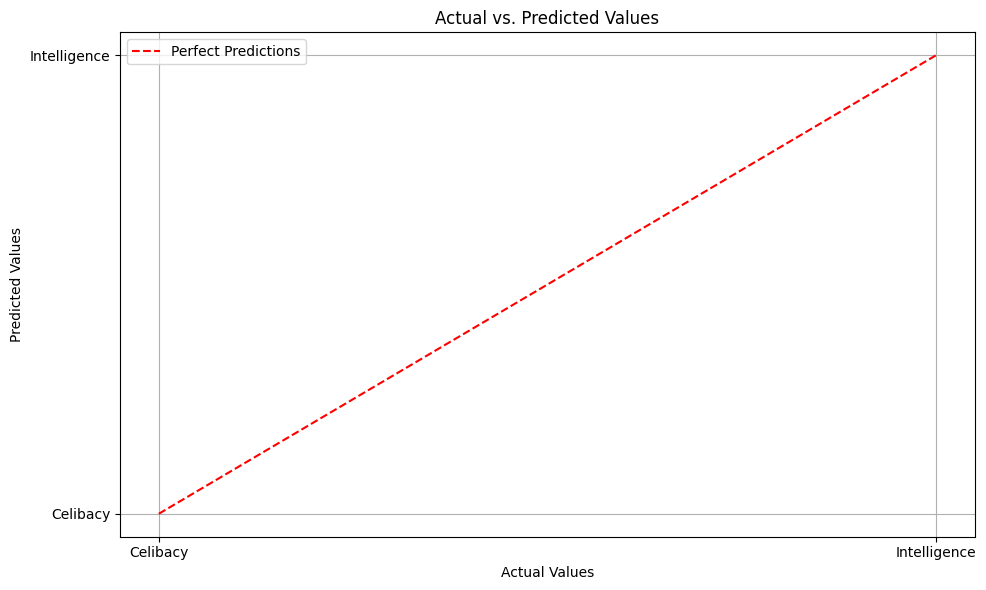

In [36]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Adding transparency to points
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Perfect Predictions')  # Plotting the diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()  # Adding legend
plt.grid()
plt.tight_layout()  # Adjusting layout
plt.show()


# **For Testing the model**

In [ ]:
# Assuming you already have X_test prepared

# Make predictions on the testing data
predicted_scores = rf_model.predict(X_test)

# Output predictions for each individual
for i, predicted_score in enumerate(predicted_scores):
    print(f"Predicted Scores for Individual {i+1}:")
    print("Intelligence:", predicted_score['Intelligence'])
    print("Cooperativeness:", predicted_score['Cooperativeness'])
    print("Celibacy:", predicted_score['Celibacy'])
    print()


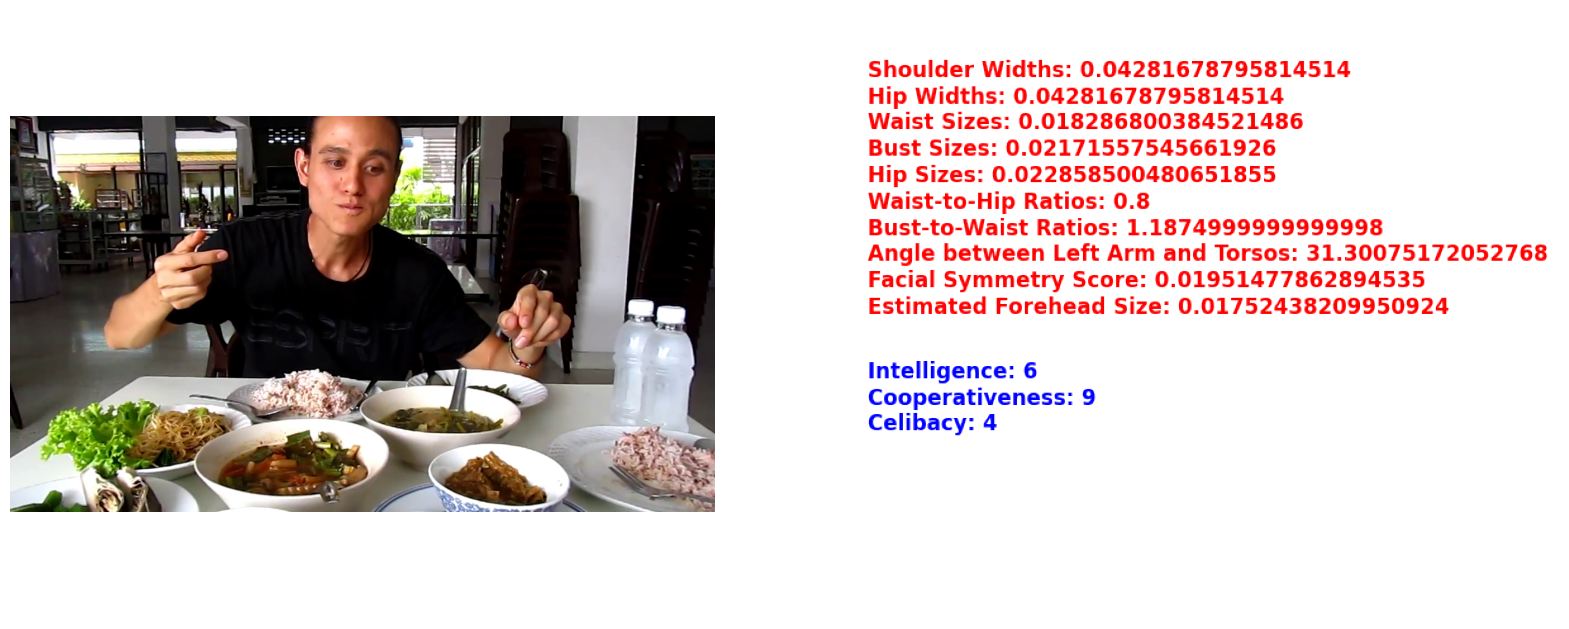

In [36]:
import matplotlib.pyplot as plt

# Load the image
image = plt.imread('/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images/000099186.jpg')

# Define extracted features
extracted_features = {
    "Shoulder Widths": test_shoulder_width[0],
    "Hip Widths": test_hip_width[0],
    "Waist Sizes": test_waist_size[0],
    "Bust Sizes": test_bust_size[0],
    "Hip Sizes": test_hip_size[0],
    "Waist-to-Hip Ratios": test_waist_to_hip_ratio[0],
    "Bust-to-Waist Ratios": test_bust_to_waist_ratio[0],
    "Angle between Left Arm and Torsos": test_angle_left_arm_torso[0],
    "Facial Symmetry Score": test_facial_symmetry_score,
    "Estimated Forehead Size": test_forehead_size
}

# Format and prepare extracted features text
feature_text = '\n'.join([f"{key}: {value}" for key, value in extracted_features.items()])

# Define predicted outputs
predicted_outputs = {
    'Intelligence': intelligence_scores[0],
    'Cooperativeness': cooperativeness_scores[5],
    'Celibacy': celibacy_scores[6]
}

# Format and prepare predicted outputs text
output_text = '\n'.join([f"{key}: {value}" for key, value in predicted_outputs.items()])

# Create a separate plot for the text
plt.figure(figsize=(6, 6))  # Set the figure size for text
plt.text(0, 0.5, feature_text, fontsize=12, family='sans-serif', weight='bold',color='red')  # Adjust the text position, size, font family, and weight as needed
plt.text(0, 0.3, output_text, fontsize=12, family='sans-serif', weight='bold',color='blue')  # Adjust the text position, size, font family, and weight as needed
plt.axis('off')  # Turn off axis ticks and labels
plt.savefig('text.png', bbox_inches='tight', transparent=True)  # Save the text plot to an image with transparency
plt.close()

# Load the saved text image
text_image = plt.imread('text.png')

# Display the text image alongside the original image
fig, axes = plt.subplots(1, 2, figsize=(20, 20))  # Create a subplot with 1 row and 2 columns
axes[0].imshow(image)  # Display the original image
axes[0].axis('off')  # Turn off axis ticks and labels
axes[1].imshow(text_image)  # Display the text image
axes[1].axis('off')  # Turn off axis ticks and labels
plt.show()


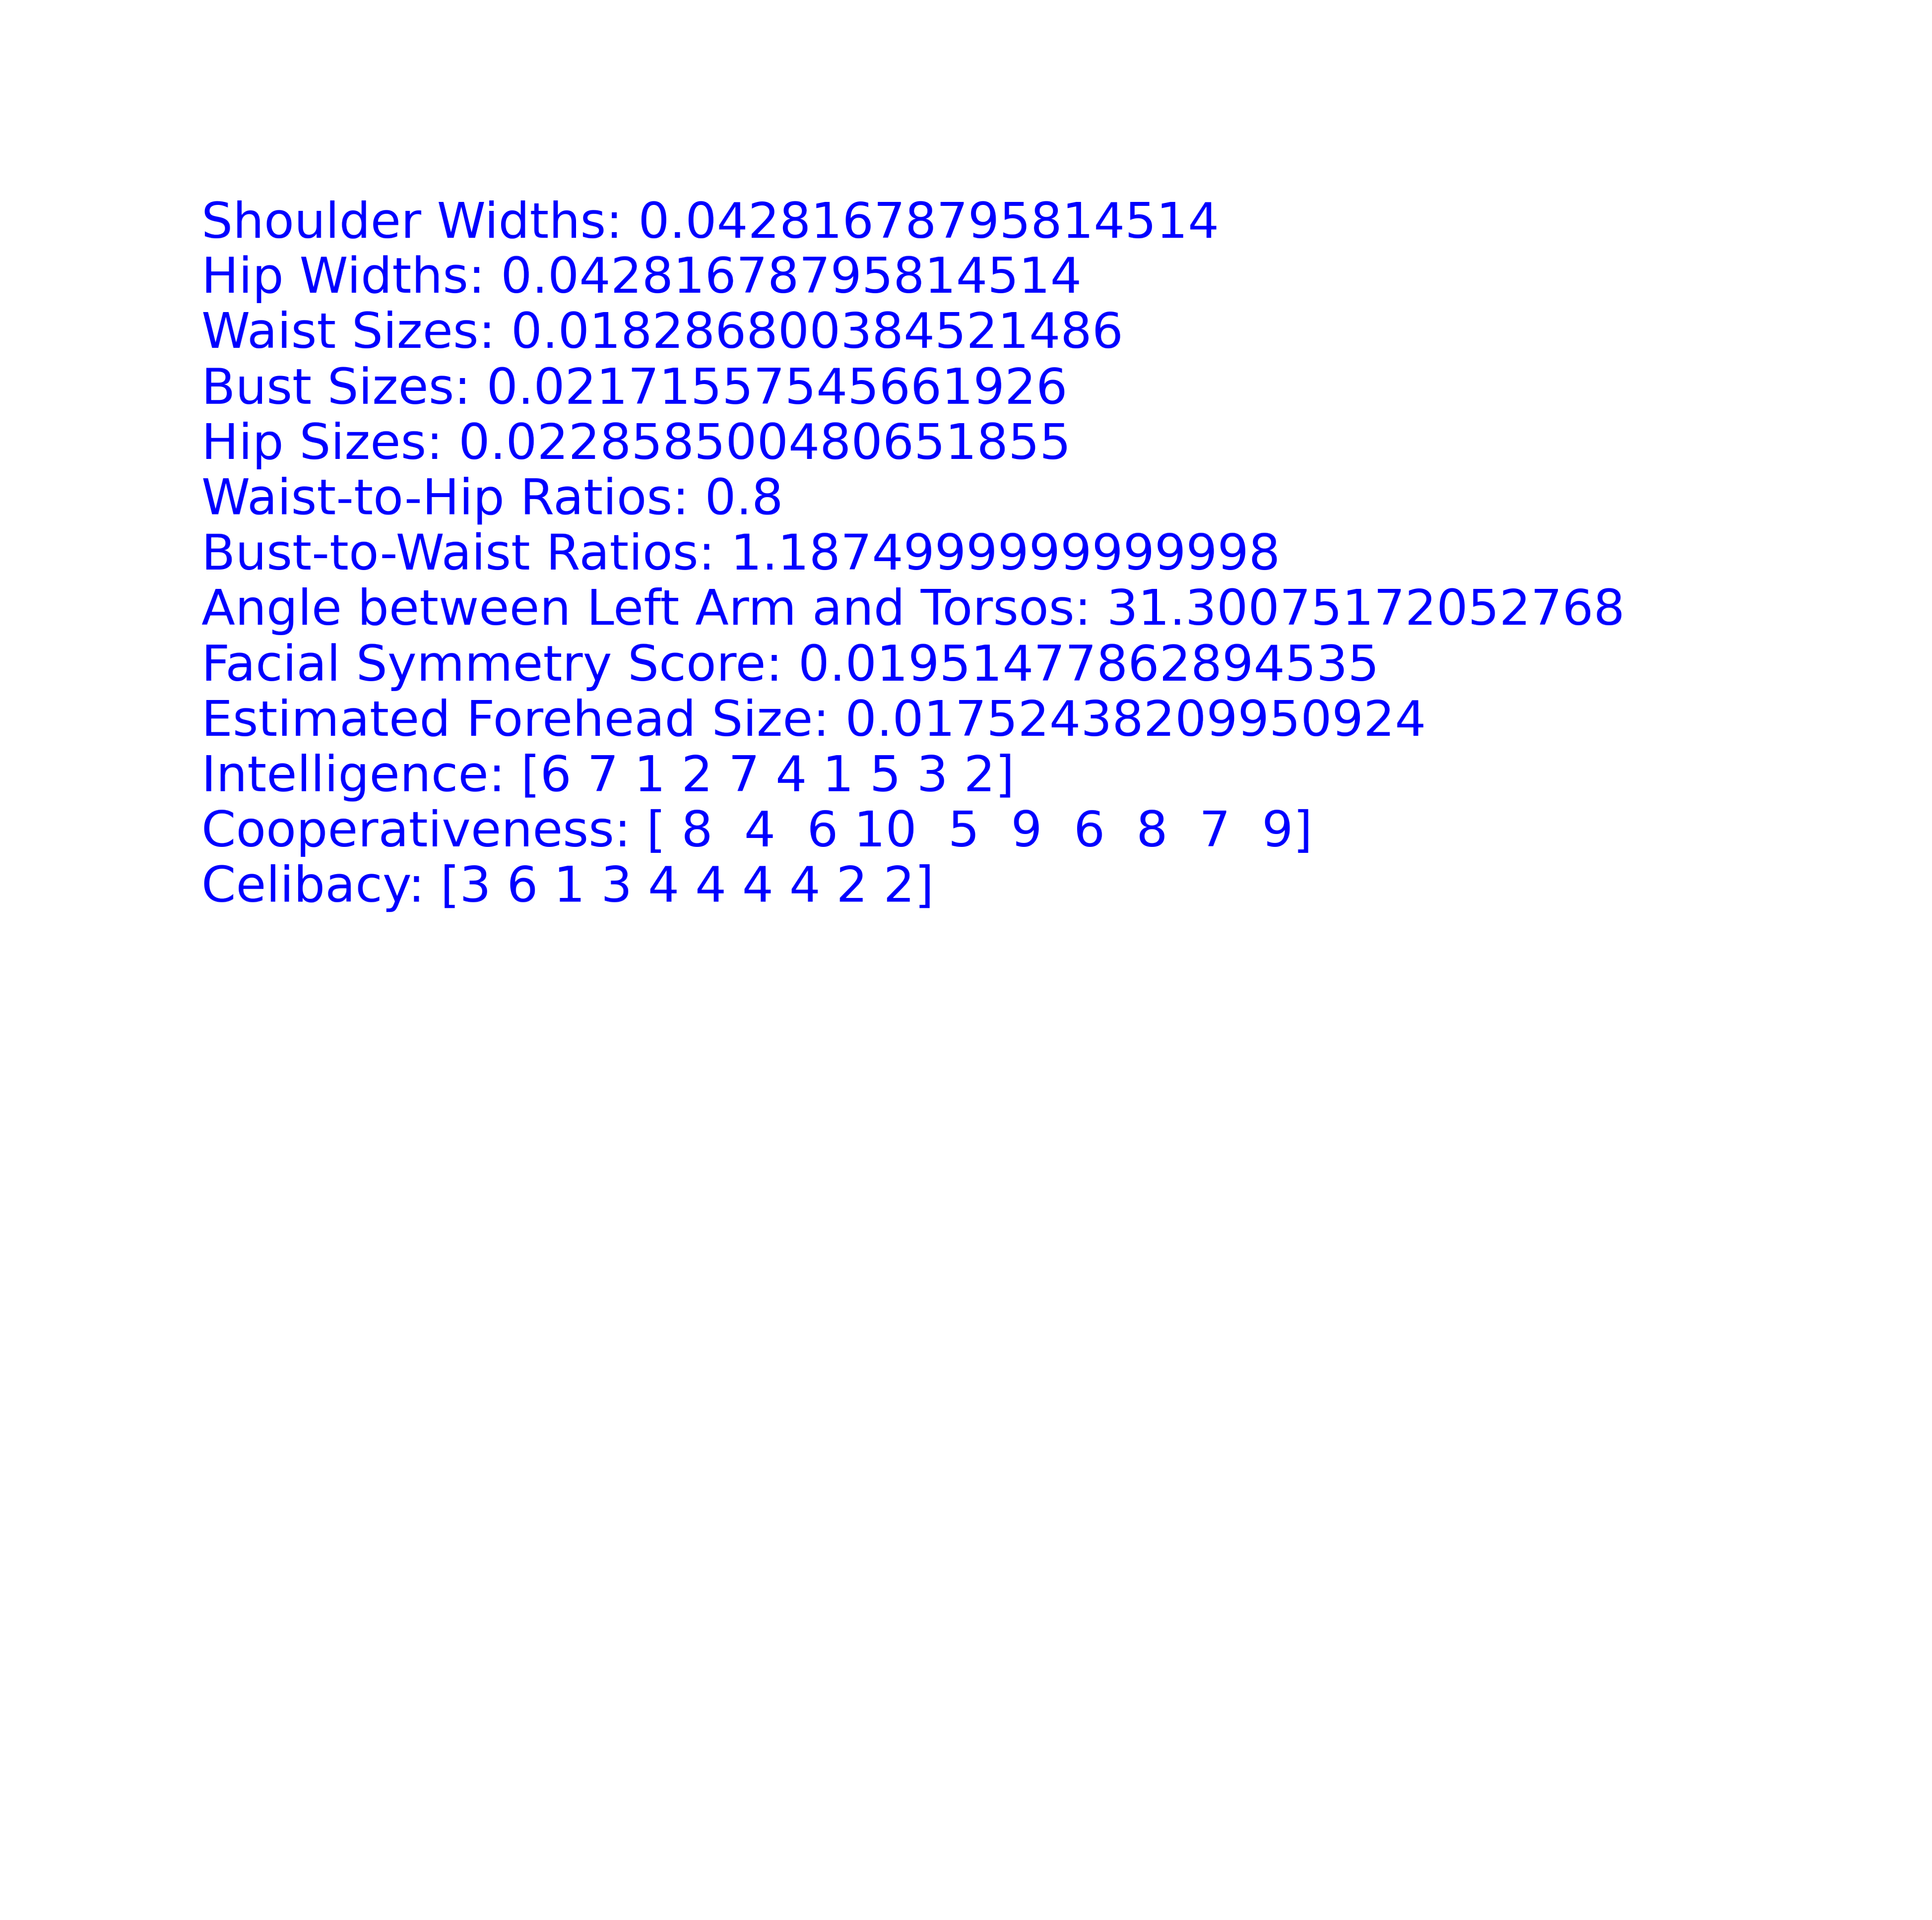

In [30]:
import matplotlib.pyplot as plt

# Define extracted features
extracted_features = {
    "Shoulder Widths": test_shoulder_width[0],
    "Hip Widths": test_hip_width[0],
    "Waist Sizes": test_waist_size[0],
    "Bust Sizes": test_bust_size[0],
    "Hip Sizes": test_hip_size[0],
    "Waist-to-Hip Ratios": test_waist_to_hip_ratio[0],
    "Bust-to-Waist Ratios": test_bust_to_waist_ratio[0],
    "Angle between Left Arm and Torsos": test_angle_left_arm_torso[0],
    "Facial Symmetry Score": test_facial_symmetry_score,
    "Estimated Forehead Size": test_forehead_size
}

# Define predicted outputs
predicted_outputs = {
    'Intelligence': intelligence_scores,
    'Cooperativeness': cooperativeness_scores,
    'Celibacy': celibacy_scores
}

# Combine feature and output texts
text = ""
for key, value in extracted_features.items():
    text += f"{key}: {value}\n"
for key, value in predicted_outputs.items():
    text += f"{key}: {value}\n"

# Create a separate plot for the text
plt.figure(figsize=(50, 50))  # Set the figure size for text
plt.text(0.1, 0.9, text, fontsize=72, family='Arial', ha='left', va='top', wrap=True, color='blue')  # Adjust the text position, size, font family, and alignment as needed
plt.axis('off')  # Turn off axis ticks and labels
plt.savefig('text.png', bbox_inches='tight', transparent=True)  # Save the text plot to an image with transparency
plt.close()

# Load the saved text image
text_image = plt.imread('text.png')

# Display the text image
axes[0].figure(figsize=(50, 50))
axes[0].imshow(text_image)
axes.axis('off')
axes[1].imshow(text_image)  # Display the text image
axes[1].axis('off')  # Turn off axis ticks and labels

plt.show()


In [43]:

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model for each trait using mean squared error
mse_intelligence = mean_squared_error(intelligence_scores[:2], y_pred[:, 0])
mse_cooperativeness = mean_squared_error(cooperativeness_scores[:2], y_pred[:, 1])
mse_celibacy = mean_squared_error(celibacy_scores[:2], y_pred[:, 2])

print("Mean Squared Error - Intelligence:", mse_intelligence)
print("Mean Squared Error - Cooperativeness:", mse_cooperativeness)
print("Mean Squared Error - Celibacy:", mse_celibacy)



Mean Squared Error - Intelligence: 3.7538
Mean Squared Error - Cooperativeness: 3.663050000000001
Mean Squared Error - Celibacy: 3.5424999999999995


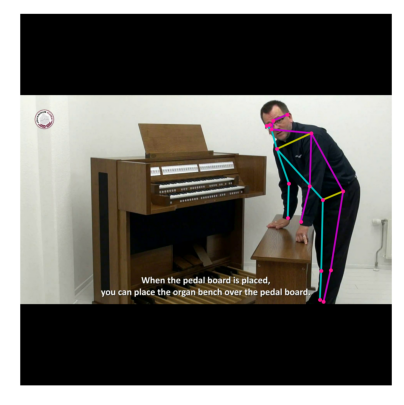

In [6]:
tests_keypoints_with_scores=[]
# Load the input image.
test_image_path = '/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images/000142573.jpg'
image = tf.io.read_file(test_image_path)
image = tf.image.decode_jpeg(image)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
test_keypoints_with_scores = movenet(input_image)
tests_keypoints_with_scores.append(test_keypoints_with_scores)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), test_keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [147]:
tests_keypoints_with_scores

[array([[[[0.31046203, 0.6765399 , 0.51462406],
          [0.28675362, 0.68084717, 0.40740645],
          [0.30087316, 0.6632322 , 0.4342163 ],
          [0.2707932 , 0.71844816, 0.61140347],
          [0.29862636, 0.67199177, 0.58481807],
          [0.3205783 , 0.7838203 , 0.734628  ],
          [0.3633951 , 0.69070375, 0.65071243],
          [0.46339518, 0.77957666, 0.36833674],
          [0.45633763, 0.7231952 , 0.5446265 ],
          [0.55962026, 0.7555307 , 0.61464643],
          [0.54891336, 0.72023314, 0.41713485],
          [0.477324  , 0.8693886 , 0.60667104],
          [0.5001825 , 0.8147451 , 0.52277535],
          [0.6894616 , 0.83588016, 0.6358153 ],
          [0.6912922 , 0.81046736, 0.48904   ],
          [0.77453625, 0.81674254, 0.1666099 ],
          [0.76910365, 0.8068136 , 0.2684122 ]]]], dtype=float32)]

In [15]:
test_left_eye_keypoint = tests_keypoints_with_scores[0][0][0][1]  # Left eye keypoints
test_right_eye_keypoint = tests_keypoints_with_scores[0][0][0][2]  # Right eye keypoints
    
test_shoulder_width, test_hip_width, test_waist_size, test_bust_size, test_hip_size, test_waist_to_hip_ratio, test_bust_to_waist_ratio, test_angle_left_arm_torso = estimate_physical_attributes(tests_keypoints_with_scores)
test_forehead_size = estimate_forehead_size([test_left_eye_keypoint, test_right_eye_keypoint])
test_facial_symmetry_score = calculate_symmetry_score(test_left_eye_keypoint, test_right_eye_keypoint)

#test_generated_texts = generate_textual_descriptions(test_input_data)


In [ ]:
df=pd.read_csv('/kaggle/input/mpii-human-pose/mpii_human_pose.csv')

In [ ]:
import json
file="/kaggle/input/mpii-human-pose/mpii_annotations.json"
# Load the JSON file
with open(file, 'r') as f:
    metadata = json.load(f)


In [ ]:
for entry in metadata[:1]:
    print("Image Path:", entry['img_paths'])
    print("KeyPoints (Self):", entry['joint_self'])
    print("KeyPoints (Self):", len(entry['joint_self']))
    print("KeyPoints (Others):", entry['joint_others'])
    print()

In [ ]:
# Access image path
image_path = metadata[0]['img_paths']
print("Image Path:", image_path)

# Access keypoints (joint coordinates) for the person in the image
keypoints_self = metadata[0]['joint_self']
print("Keypoints (Self):", keypoints_self)

# Access keypoints for other people in the image (if available)
keypoints_others = metadata[0]['joint_others']
print("Keypoints (Others):", keypoints_others)


In [ ]:


# Define a dictionary to store the associations between image IDs and keypoints
keypoints_mapping = {}

# Iterate through each entry in the JSON metadata
for entry in metadata:
    image_id = entry['img_paths']  # Get the image ID
    keypoints_self = entry['joint_self']  # Get the keypoints associated with the person in the image
    
    # Find the corresponding entry in the dataset based on the image ID
    dataset_entry = df[df['NAME'] == image_id]
    
    # Check if dataset_entry is empty
    if dataset_entry.empty:
        print(f"No entry found in the dataset for image ID: {image_id}")
        continue
    
    # Extract relevant keypoints from the dataset entry
    waist_keypoints = (dataset_entry['pelvis_X'].values[0], dataset_entry['pelvis_Y'].values[0])
    bust_keypoints = (dataset_entry['thorax_X'].values[0], dataset_entry['thorax_Y'].values[0])
    hips_keypoints = [(dataset_entry['r hip_X'].values[0], dataset_entry['r hip_Y'].values[0]),
                      (dataset_entry['l hip_X'].values[0], dataset_entry['l hip_Y'].values[0])]
    #head_keypoints=(dataset_entry['head top_X'].values[0], dataset_entry['head top_Y'].values[0])
    
    # Store the associations in the dictionary
    keypoints_mapping[image_id] = {'waist': waist_keypoints, 'bust': bust_keypoints, 'hips': hips_keypoints}
    




In [ ]:
''''import os
import cv2
# Define the directory containing the images
images_directory = '/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images'
nload_images=100
# Define a function to load images given their paths
def load_images(image_paths):
    images = []
    for image_path in image_paths:
        # Construct the full path to the image
        full_image_path = os.path.join(images_directory, image_path)
        # Load the image using OpenCV
        image = cv2.imread(full_image_path)
        # OpenCV reads images in BGR format by default, so we need to convert it to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return images

# Extract image paths from metadata
image_paths = [os.path.join(images_directory, element['img_paths']) for element in metadata]

# Load the images
images = load_images(image_paths[:nload_images])

# Print the number of images loaded
print("Number of Images Loadimagesed:", len(images))
''''

In [ ]:
'''for element in metadata:
    if 'waist' not in element or 'bust' not in element or 'hips' not in element:
        print("Keys:", element.keys())
'''

In [ ]:
nload_images=3000
imge_size=256
images_directory = '/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images'

# Function to load images and labels
def load_images_and_labels(metadata, images_directory, nload_images):
    images = []
    labels = []

    # Iterate through each entry in the JSON metadata
    for entry in metadata[:nload_images]:
        image_id = entry['img_paths']  # Get the image ID
        
        # Check if the image ID exists in the keypoints_mapping dictionary
        if image_id in keypoints_mapping:
            # Load image
            image_path = os.path.join(images_directory, image_id)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image,(imge_size,imge_size))
            images.append(image)
            
           # Load label
            label = keypoints_mapping.get(entry['img_paths'])
            labels.append(label)
        else:
            print(f"No keypoints found for image ID: {image_id}")

    return images, labels

# Load images and labels
images, labels = load_images_and_labels(metadata, images_directory, nload_images)

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [ ]:
# Define a function to convert labels to numerical format
def convert_labels_to_numerical(labels):
    numerical_labels = []
    for label in labels:
        numerical_label = np.zeros((3, 2))  # Initialize array to store numerical label
        for i, keypoint in enumerate(['waist', 'bust', 'hips']):
            if isinstance(label[keypoint], tuple):  # Single coordinate
                numerical_label[i] = label[keypoint]
            elif isinstance(label[keypoint], list):  # Multiple coordinates (e.g., hips)
                numerical_label[i] = np.mean(label[keypoint], axis=0)  # Use mean of coordinates
        numerical_labels.append(numerical_label)
    return np.array(numerical_labels)

In [ ]:
# Initialize array to store numerical label
numerical_label = np.zeros((len(keypoints_mapping), 2))

# Iterate over keypoints in the label and update numerical label
for keypoint, keypoints_list in keypoints_mapping.items():
    index = keypoints_mapping[keypoint]
    if isinstance(keypoints_list, tuple):  # Single coordinate
        numerical_label[index] = keypoints_list
    elif isinstance(keypoints_list, list):  # Multiple coordinates (e.g., hips)
        # Take the mean of the coordinates
        mean_x = sum(coord[0] for coord in keypoints_list) / len(keypoints_list)
        mean_y = sum(coord[1] for coord in keypoints_list) / len(keypoints_list)
        numerical_label[index] = (mean_x, mean_y)

print("Numerical label:")
print(numerical_label[3])


In [ ]:
numerical_labels[0]

In [ ]:

nload_images=50
images_directory = '/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images'

def load_images_and_labels(metadata, images_directory, nload_images):
    images = []
    labels = []
    for entry in metadata[:nload_images]:
        image_path = os.path.join(images_directory, entry['img_paths'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        
        # Assuming labels are stored in the 'keypoints_mapping' dictionary
        label = keypoints_mapping.get(entry['img_paths'])
        labels.append(label)
        
    return images, labels


In [ ]:
images,labels=load_images_and_labels(metadata,images_directory,nload_images)

In [ ]:
flattened_data = []

for entry in labels_i:
    sublist = []
    for key, value in entry.items():
        if key == 'hips':
            sublist.extend([list(item) for item in value])
        else:
            sublist.append(list(value))
    flattened_data.append(sublist)

print(flattened_data[0])

In [ ]:
import matplotlib.pyplot as plt # Display the shapes of X_train and y_train
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
sample_indices = [0, 1, 2, 3, 40, 5, 18, 7, 9, 34]

'''# Display a few examples
for i in sample_indices:
    print("\nExample", i+1)
    print("Image:")
    plt.imshow(X_train[i])
    plt.show()
    print("One-Hot Encoded Label:", y_train[i])
'''

In [ ]:
import numpy as np

# Assuming y_train is your data array
y_train_2d = y_train[:, :, :2]  # Select only the first two coordinates (x, y)
y_test_2d=y_test[:,:, :2]

In [ ]:
y_train_2d.shape

In [ ]:
# Reshape the ground truth labels to match the output shape of the model
y_train_reshaped = y_train.reshape(-1, 6)
y_test_reshaped = y_test.reshape(-1, 6)

# Check the shape of the reshaped labels
print("Reshaped training labels shape:", y_train_reshaped.shape)
print("Reshaped testing labels shape:", y_test_reshaped.shape)


In [ ]:
X_train_list = X_train.tolist()
x_test_list = x_test.tolist()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(input_shape=(128, 128, 3), num_keypoints=16):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_keypoints * 2)  # 16 sets of 2 coordinates
        
    ])
    model.add(layers.Reshape((16, 2)))
    return model

# Create the modelloss='mean_squared_error', metrics=['mae']
model = create_model()
#model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
  model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(X_train, y_train_2d, batch_size=64)

test2 = test_datagen.flow(
        X_test, y_test_2d,
        batch_size=64)

history1 = model.fit(train2, epochs=50, shuffle=True, validation_data=test2)


In [ ]:
# Plot training and validation loss
history1 = model.fit(train2, epochs=50, shuffle=True, validation_data=test2)

plt.plot(history1.history1['loss'], label='Training Loss')
plt.plot(history1.history1['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
def preprocess_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Resize the image to match the input shape of your model
    resized_image = cv2.resize(image, (128, 128))
    # Normalize the pixel values to be in the range [0, 1]
    normalized_image = resized_image / 255.0
    # Convert the image to a numpy array
    image_array = np.array([normalized_image])
    return image_array

# Define a function to predict labels for an image
def predict_labels(image_path, model):
    # Preprocess the image
    image_array = preprocess_image(image_path)
    # Make predictions using the model
    predictions = model.predict(image_array)
    return predictions

# Path to the image you want to predict labels for
image_path = '/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images/000094304.jpg'

# Predict labels for the image
predictions = predict_labels(image_path, model)

# Load the image using OpenCV
image = cv2.imread(image_path)

# Display the image using Matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image')
plt.axis('off')
plt.show()

# Print the predictions
print("Predictions:")
print(predictions)


In [ ]:
df[df['NAME'] == '000094304.jpg'][['r ankle_X', 'r ankle_Y','r knee_X', 'r knee_Y',
       'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 'l knee_X', 'l knee_Y',
       'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X']]

In [ ]:
df.columns

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to visualize keypoints overlaid on images
def visualize_keypoints(image, keypoints, title=""):
    # Create a copy of the image to avoid modifying the original
    vis_image = np.copy(image)
    
    # Iterate over keypoints and draw them on the image
    for keypoint in keypoints:
        if not keypoint or not isinstance(keypoint, (list, tuple)):
            continue  # Skip empty or non-list/tuple keypoint elements
        if len(keypoint) == 3:
            # Keypoint contains (x-coordinate, y-coordinate, visibility)
            x, y, visibility = keypoint
            if visibility == 1:
                cv2.circle(vis_image, (int(x), int(y)), 3, (0, 255, 0), -1)  # Green color
            else:
                cv2.circle(vis_image, (int(x), int(y)), 3, (255, 0, 0), -1)  # Red color (for non-visible keypoints)
        elif len(keypoint) == 2:
            # Keypoint contains only (x-coordinate, y-coordinate)
            x, y = keypoint
            cv2.circle(vis_image, (int(x), int(y)), 5, (0, 255, 0), -1)  # Green color
        
    # Display the image with keypoints
    plt.figure(figsize=(8, 8))
    plt.imshow(vis_image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Choose a random image index
random_image_index = np.random.randint(len(images))

# Get the random image and its keypoints
random_image = images[random_image_index]
random_keypoints_self = metadata[random_image_index]['joint_self']
random_keypoints_others = metadata[random_image_index]['joint_others']

# Visualize keypoints overlaid on the random image
# Visualize keypoints overlaid on the random image
visualize_keypoints(random_image, random_keypoints_self, title="Keypoints (Self)")
for keypoints_others in random_keypoints_others:
    visualize_keypoints(random_image, keypoints_others, title="Keypoints (Others)")
